In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
vocab_size = 32000
hidden_size = 400
A = torch.randn((vocab_size, hidden_size)) / hidden_size # generate A so that Ah ~ normal(0,1)
h = torch.randn((hidden_size, 1))
b = torch.randn((vocab_size, 1))

In [4]:
def Softmax(A, h, b):
    L = torch.autograd.Variable(F.linear(h.transpose(0, 1), weight=A, bias=b[:, 0]))
    return F.softmax(L, dim=1).data.transpose(0, 1)

def SVDSoftmax(A, h, b, W_size, N_size, B, V_t):
    h = torch.mm(V_t,h)
    z = torch.zeros_like(b)
    torch.add(torch.mm(B[:, :W_size], h[:W_size]), b, out=z)

    top_k_ind = torch.topk(z, k=N_size, dim=0, sorted=False)[1][:,0]
    torch.add(torch.mm(B[top_k_ind], h), b[top_k_ind], out=z[top_k_ind])
    z_exp = torch.exp(z - torch.max(z))
    return z_exp / z_exp.sum()

SVD transformation of weight matrix A:

In [5]:
U, S, V = torch.svd(A)
V_t = V.transpose(0, 1)
B = U * S

Comparing on parametrs from the article:

In [8]:
W_size = int(hidden_size / 8) #= 256
N_size = int(vocab_size / 10) #16000
%timeit SVDSoftmax(A, h, b, W_size, N_size, B, V_t)

100 loops, best of 3: 3.65 ms per loop


In [10]:
%timeit Softmax(A, h, b)

100 loops, best of 3: 5.5 ms per loop


### Dependency from window size, N = vocab_size * 0.1

In [11]:
import time
W = [16, 32, 64, 128, 256, 512, 1024, 1500, 2000]
exec_time_softmaxSVD = []

for W_size in W:
    t_start = time.process_time()
    SVDSoftmax(A, h, b, W_size, N_size, B, V_t)
    t_end = time.process_time()
    exec_time_softmaxSVD.append(t_end - t_start)

In [12]:
t_start = time.process_time()
SVDSoftmax(A, h, b, W_size, N_size, B, V_t)
t_end = time.process_time()
exec_time_softmax = t_end - t_start

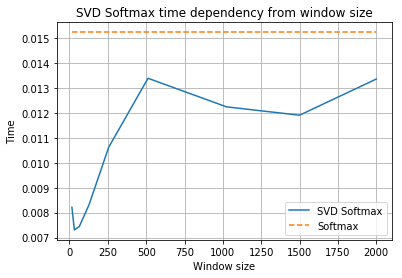

In [13]:
plt.plot(W, exec_time_softmaxSVD, label='SVD Softmax')
plt.plot(W, [exec_time_softmax for _ in W], label='Softmax', linestyle='dashed')
plt.legend()
plt.title('SVD Softmax time dependency from window size')
plt.xlabel('Window size')
plt.ylabel('Time')
plt.grid()

### Dependency from full-view size, W = 256

In [15]:
import time
import numpy as np
N_percentage_view = np.array([0.01, 0.05, 0.1, 0.15, 0.2])
exec_time_softmaxSVD_N = []
# W_size=256
W_size = int(hidden_size / 8) #= 256
for N_view in N_percentage_view:
    t_start = time.process_time()
    SVDSoftmax(A, h, b, W_size, int(N_view * vocab_size), B, V_t)
    t_end = time.process_time()
    exec_time_softmaxSVD_N.append(t_end - t_start)

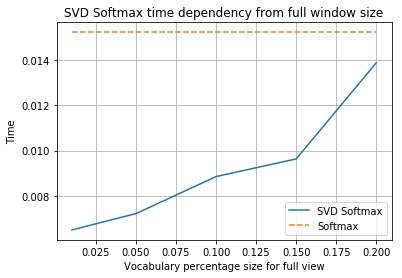

In [16]:
plt.plot(N_percentage_view, exec_time_softmaxSVD_N, label='SVD Softmax')
plt.plot(N_percentage_view, [exec_time_softmax for _ in N_percentage_view], label='Softmax', linestyle='dashed')
plt.legend()
plt.title('SVD Softmax time dependency from full window size')
plt.xlabel('Vocabulary percentage size for full view')
plt.ylabel('Time')
plt.grid()